# 개, 고양이 분류 V1
- 부분 데이터: 훈련 개, 고양이 각각 1000개, 테스트 각각 500개

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-01-14 05:53:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  21.1MB/s    in 3.1s    

2023-01-14 05:53:37 (21.1 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 탐색

In [4]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [5]:
# 파일 이름 확인
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.706.jpg', 'cat.243.jpg', 'cat.265.jpg', 'cat.271.jpg', 'cat.666.jpg']
['dog.760.jpg', 'dog.76.jpg', 'dog.492.jpg', 'dog.149.jpg', 'dog.282.jpg']


In [6]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

- 이미지 확인

In [7]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

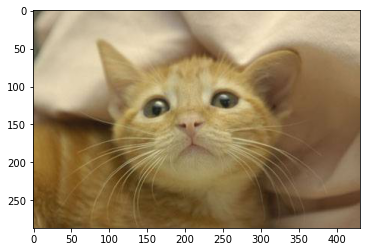

In [8]:
# 1) Pillow image
from PIL import Image
img = Image.open(fname)
plt.imshow(img);

In [9]:
img.width, img.height

(431, 287)

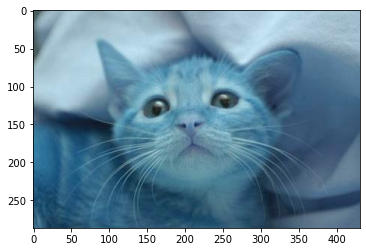

In [10]:
# 2) OpenCV image, 컬러 읽는 순서: BGR
import cv2
img2 = cv2.imread(fname)
plt.imshow(img2);

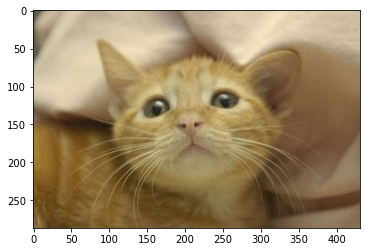

In [11]:
img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img3);

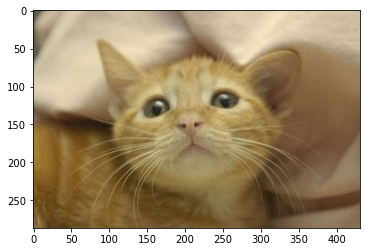

In [12]:
# OpenCV의 데이터는 numpy array
img4 = img2[:,:,::-1]
plt.imshow(img4);

In [13]:
img4.shape

(287, 431, 3)

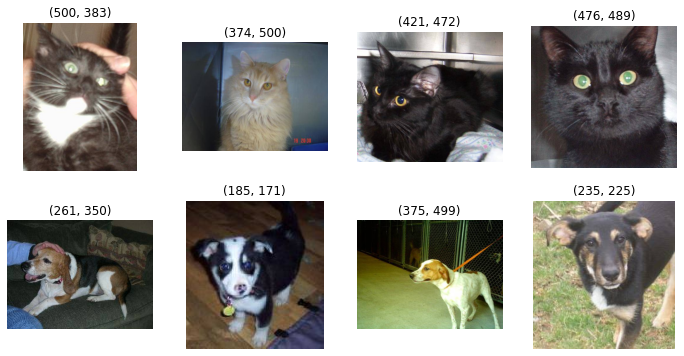

In [14]:
# 실제 여러개 모습
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])

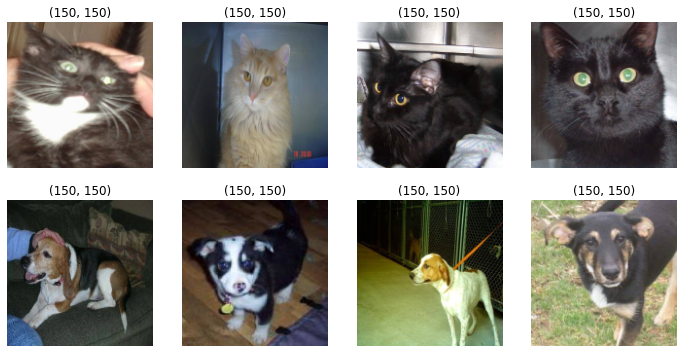

In [15]:
# size를 150, 150으로 변환
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    cat = cv2.resize(cat, dsize=(150,150), interpolation=cv2.INTER_AREA)
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    dog = cv2.resize(dog, dsize=(150,150), interpolation=cv2.INTER_AREA)
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])

- 모델 구성

In [16]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
model = Sequential([ 
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [18]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [19]:
model_path = 'best_model.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

- 파일에서 이미지 데이터 읽어서 학습시키는 방법

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [21]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 모델 학습

In [22]:
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    steps_per_epoch=100,
    validation_steps=50,
    callbacks=[mc, es]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.5665
Epoch 1: val_loss improved from inf to 0.61705, saving model to best_model.h5
100/100 [==============================] - 17s 89ms/step - loss: 0.7581 - accuracy: 0.5665 - val_loss: 0.6170 - val_accuracy: 0.6590
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.6950
Epoch 2: val_loss improved from 0.61705 to 0.58793, saving model to best_model.h5
100/100 [==============================] - 9s 87ms/step - loss: 0.5954 - accuracy: 0.6950 - val_loss: 0.5879 - val_accuracy: 0.6850
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.7445
Epoch 3: val_loss improved from 0.58793 to 0.56310, saving model to best_model.h5
100/100 [==============================] - 10s 96ms/step - loss: 0.5279 - accuracy: 0.7445 - val_loss: 0.5631 - val_accuracy: 0.7200
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss

In [23]:
best_model = load_model(model_path)
best_model.evaluate(test_generator)

50/50 [==============================] - 3s 57ms/step - loss: 0.5631 - accuracy: 0.7200


[0.5630954504013062, 0.7200000286102295]